In [50]:
from torchvision import transforms as T
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from skimage.metrics import structural_similarity as ssim

model = SentenceTransformer('clip-ViT-B-32')
PATCH_SIZE = 32

In [51]:
def extract_patches(image, n, m):  
    patches = []
    image = np.array(image)
    height, width = image.shape[:2]
    images_height =0
    images_width = 0

    for y in range(0, height - n + 1, m):
        images_height += 1
        for x in range(0, width - n + 1, m):  
            images_width += 1          
            patch = image[y:y+n, x:x+n]
            patches.append(patch)
    images_width = images_width//images_height

    return np.array([patch for patch in patches]), images_width, images_height

In [52]:
img = Image.open('sit_toyosu.png')
gray = img.convert('L')
ascii = Image.open('converted_sit_toyosu.png').resize(img.size)
normal_imgs, _, _ = extract_patches(gray, PATCH_SIZE, PATCH_SIZE)
ascii_imgs, _, _ = extract_patches(ascii, PATCH_SIZE, PATCH_SIZE)

In [53]:
def score_image(image1, image2):
    encoded_image = model.encode([Image.fromarray(image1),Image.fromarray(image2)], batch_size=128, convert_to_tensor=True)
    processed_images = util.paraphrase_mining_embeddings(encoded_image)
    return processed_images

In [54]:
scores = []

for ascii_img, normal_img in zip(ascii_imgs, normal_imgs):
    scores.append(score_image(ascii_img, normal_img))

In [55]:
scores_ssim = []
for ascii_img, normal_img in zip(ascii_imgs, normal_imgs):
    score, diff = ssim(ascii_img, normal_img, full=True)
    if score < 0:
        score = 0
    scores_ssim.append(score * 100)

In [61]:
for i, score in enumerate(scores_ssim):
    print(f'Image {i} : {score:.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 1.58%
Image 1 : 2.36%
Image 2 : 2.76%
Image 3 : 1.34%
Image 4 : 4.27%
Image 5 : 10.11%
Image 6 : 4.04%
Image 7 : 3.07%
Image 8 : 2.65%
Image 9 : 2.37%
Image 10 : 3.71%
Image 11 : 2.93%
Image 12 : 2.11%
Image 13 : 3.18%
Image 14 : 2.86%
Image 15 : 2.86%
Image 16 : 2.78%
Image 17 : 2.78%
Image 18 : 2.85%
Image 19 : 2.84%
Image 20 : 2.77%
Image 21 : 2.75%
Image 22 : 2.70%
Image 23 : 2.94%
Image 24 : 2.86%
Image 25 : 2.79%
Image 26 : 2.30%
Image 27 : 1.54%
Image 28 : 1.69%
Image 29 : 1.45%
Image 30 : 4.34%
Image 31 : 13.43%
Image 32 : 4.20%
Image 33 : 6.89%
Image 34 : 8.62%
Image 35 : 1.14%
Image 36 : 2.23%
Image 37 : 3.89%
Image 38 : 3.23%
Image 39 : 2.85%
Image 40 : 3.05%
Image 41 : 2.93%
Image 42 : 2.89%
Image 43 : 3.66%
Image 44 : 2.84%
Image 45 : 2.81%
Image 46 : 2.79%
Image 47 : 2.85%
Image 48 : 2.87%
Image 49 : 2.71%
Image 50 : 2.75%
Image 51 : 2.74%
Image 52 : 2.82%
Image 53 : 2.94%
Image 54 : 2.78%
Image 55 : 2.76%
Image 56 : 2.70%
Image 57 : 2.29%
Image 58 : 1.66%
Image

In [63]:
for i, score in enumerate(scores):
    print(f'Image {i} : {(score[0][0]*100):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 84.27%
Image 1 : 85.43%
Image 2 : 88.12%
Image 3 : 89.25%
Image 4 : 89.50%
Image 5 : 87.75%
Image 6 : 85.91%
Image 7 : 90.69%
Image 8 : 89.88%
Image 9 : 88.03%
Image 10 : 89.10%
Image 11 : 87.13%
Image 12 : 89.05%
Image 13 : 88.66%
Image 14 : 89.35%
Image 15 : 88.40%
Image 16 : 88.82%
Image 17 : 88.62%
Image 18 : 89.01%
Image 19 : 89.31%
Image 20 : 89.06%
Image 21 : 88.64%
Image 22 : 88.61%
Image 23 : 88.71%
Image 24 : 89.01%
Image 25 : 88.83%
Image 26 : 86.64%
Image 27 : 84.65%
Image 28 : 83.26%
Image 29 : 83.84%
Image 30 : 83.49%
Image 31 : 79.93%
Image 32 : 80.18%
Image 33 : 89.87%
Image 34 : 90.54%
Image 35 : 88.83%
Image 36 : 87.79%
Image 37 : 84.97%
Image 38 : 89.13%
Image 39 : 87.18%
Image 40 : 86.99%
Image 41 : 87.24%
Image 42 : 87.32%
Image 43 : 88.16%
Image 44 : 88.68%
Image 45 : 87.36%
Image 46 : 87.49%
Image 47 : 86.88%
Image 48 : 86.87%
Image 49 : 87.49%
Image 50 : 87.26%
Image 51 : 87.38%
Image 52 : 87.53%
Image 53 : 87.36%
Image 54 : 86.94%
Image 55 : 87.12%
Im

Image similarity : 6.63%


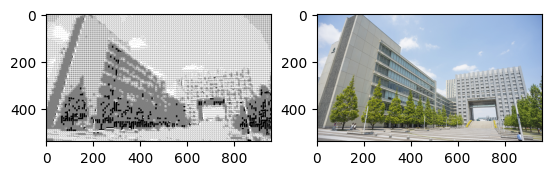

In [64]:
image_mean = np.array(scores_ssim).mean()
print(f'Image similarity : {image_mean:.2f}%')
plt.subplot(1, 2, 1)
plt.imshow(ascii, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()

Image similarity : 62.14%


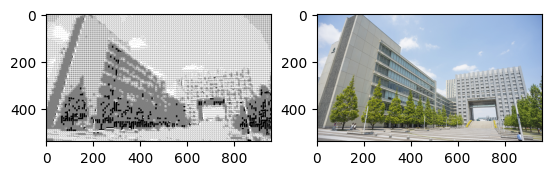

In [65]:
image_mean = np.array(scores).mean()
print(f'Image similarity : {(image_mean*100):.2f}%')
plt.subplot(1, 2, 1)
plt.imshow(ascii, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()